In [1]:
import sys, os
sys.path.append('../')
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from inversion_attacks import GradientInversion_Attack
from inversion_attacks.utils.utils import NumpyDataset, ConservativeStrategy, plot, multi_plot
from inversion_attacks.utils.models import LeNet, ConvNet, MoCo
from inversion_attacks.utils.evaluation_metrics import psnr
from inversion_attacks.utils.consts import *
from inversion_attacks.utils.dataloader import construct_dataloaders

import numpy as np
from PIL import Image

from IQA_pytorch import SSIM 
import lpips 
import csv 
from vit_pytorch import ViT

In [2]:
torch.manual_seed(1)
num_classes = 1000
channel = 3
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
setup = dict(device=device, dtype=torch.float)  
print(setup)
defs = ConservativeStrategy()
batch_size = 1

{'device': device(type='cuda', index=0), 'dtype': torch.float32}


In [3]:
# dm = torch.as_tensor(imagenet_mean, **setup)[:, None, None] 
# ds = torch.as_tensor(imagenet_std, **setup)[:, None, None] 

dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None] 

loss_fn, dataloader, validloader =  construct_dataloaders('ImageNet', defs,data_path='/data2/imagenet2012/')

In [4]:
img_idx = 8112
img, label = validloader.dataset[img_idx]
labels = torch.as_tensor((label,), device=device)
ground_truth = img.to(**setup).unsqueeze(0)
shape_img=tuple(ground_truth[0].shape)

print(shape_img)
print(ground_truth.shape)
print("seed label: ", labels, labels.shape)

(3, 224, 224)
torch.Size([1, 3, 224, 224])
seed label:  tensor([162], device='cuda:0') torch.Size([1])


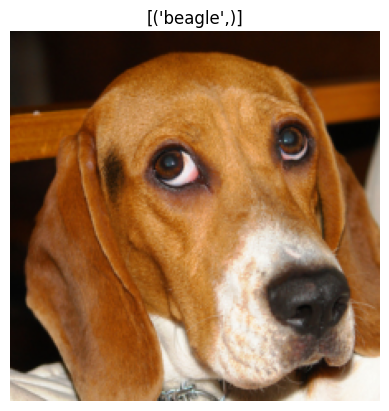

In [5]:
img = ground_truth.clone().detach().to(**setup)
img.mul_(ds).add_(dm).clamp_(0, 1)
plt.imshow(img[0].permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(str([validloader.dataset.classes[l] for l in labels]))
plt.show()

In [6]:
checkpoint = torch.load('/home/msyu/code/ViT_Inversion/demodata/moco_v2_200ep_pretrain.pth.tar')
image_prior_model = MoCo( models.__dict__['resnet50'],128,65536,0.999,0.2,True)

In [7]:
## image prior model
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
        k_no_prefix = k[len("module."):]
        state_dict[k_no_prefix] = state_dict[k]
        state_dict[k_no_prefix.replace('encoder_q', 'encoder_k')] = state_dict[k]
    del state_dict[k]

image_prior_model.load_state_dict(state_dict, strict=False)
image_prior_model.train()
image_prior_model.to(device)
print()

In [8]:
# net = getattr(torchvision.models, 'resnet50')()
# net = getattr(torchvision.models, 'resnet18')()
# net = LeNet(channel=channel, hideen=37632, num_classes=num_classes)
# net = ConvNet(num_classes=num_classes)
net = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
net = net.to(device)

In [9]:
ip_bn_reg_layers = list()
for layer in image_prior_model.modules():
    if isinstance(layer,torch.nn.modules.batchnorm.BatchNorm2d): 
        ip_bn_reg_layers.append(layer)
print(len(ip_bn_reg_layers))

106


In [10]:
bn_reg_layers = list()
for layer in net.modules():
    if isinstance(layer,torch.nn.modules.batchnorm.BatchNorm2d): 
        bn_reg_layers.append(layer)
print(len(bn_reg_layers))

0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


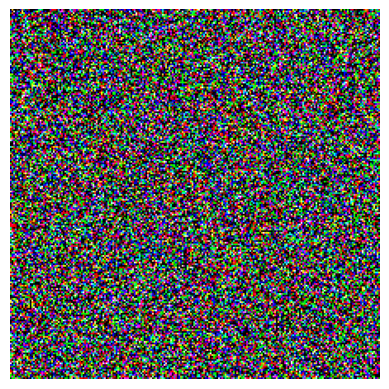

In [11]:
# x_init = torch.randn(ground_truth.shape,requires_grad=True,).to(**setup)
x_init = torch.randn((batch_size,) + (shape_img), requires_grad=True, device=device)
print(x_init.shape)
plt.imshow(x_init[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.show()

In [12]:
net.eval()
net.zero_grad()
ground_truth.requires_grad = True

In [13]:
pred = net(ground_truth)
loss, _, _ = loss_fn(pred, labels)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
print(len(received_gradients))

78


In [14]:
image_prior_model.eval()
image_prior_model.zero_grad()
ground_truth.requires_grad = False
# temp = image_prior_model(ground_truth,ground_truth)

In [15]:
width_patch_num = int(ground_truth.shape[3]/16) -1
height_patch_num = int(ground_truth.shape[2]/16) -1

In [16]:
from einops import rearrange

print(ground_truth.shape) # (1, 96, 96, 3)
temp = ground_truth.detach().permute(0,2, 3, 1)
print(temp.shape) # (1, 96, 96, 3)
patchs = rearrange(temp, 'b (h s1) (w s2) c -> b (h w) s1 s2 c',  s1 = 16, s2 = 16).detach().cpu()

print(patchs.shape) # (1, 36, 16, 16, 3)
print(ground_truth.shape) 

torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 196, 16, 16, 3])
torch.Size([1, 3, 224, 224])


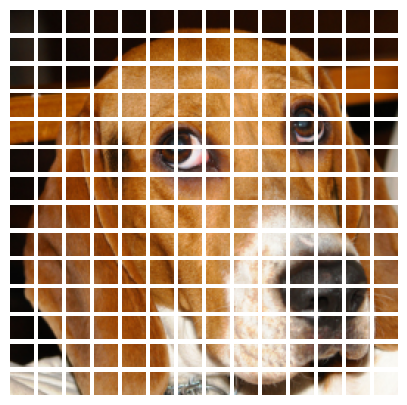

In [17]:
plt.figure(figsize = (5,5))

for index in range(patchs.shape[1]):

    plt.subplot(14, 14, index+1)
    img = patchs[0][index].clone().detach()
    img = img.permute(2,0,1)
    img.mul_(ds.detach().cpu()).add_(dm.detach().cpu()).clamp_(0, 1)
    plt.imshow(img.permute(1, 2, 0).cpu()) # patch size = (B=1, 36, 16, 16,3 ) 
    plt.axis('off')

plt.show()

In [18]:
print(ground_truth.shape) # (1, 96, 96, 3)
temp = ground_truth.detach() #.permute(0,2, 3, 1)
print(temp.shape) # (1, 96, 96, 3)
patches = rearrange(temp, 'b c (h s1) (w s2)  -> b h w s1 s2 c',  s1 = 16, s2 = 16)
print(patches.shape) # (1, 196, 16, 16, 3)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 14, 14, 16, 16, 3])


In [19]:
height_patch_num = patches.shape[1]
width_patch_num = patches.shape[2]
print(height_patch_num,width_patch_num)

14 14


In [20]:
reg = 0
for i in range(1,height_patch_num):
    reg += torch.norm(patches[:,i,:,:,:] - patches[:,i-1,:,:,:], p=2)
print(reg)
for i in range(1,width_patch_num):
    reg += torch.norm(patches[:,:,i,:,:] - patches[:,:,i-1,:,:], p=2)
print(reg)

tensor(593.9272, device='cuda:0')
tensor(1179.1556, device='cuda:0')


In [21]:
torch.norm(patches[:,1,:,:,:] - patches[:,0,:,:,:], p=2)

tensor(44.7868, device='cuda:0')

In [22]:
attacker = GradientInversion_Attack(
            net,
            shape_img,
            mean_std=(dm,ds),
            num_iteration=10000,#20000,
            lr=0.1,#0.1,
            optimizer_class=torch.optim.Adam,
            log_interval=100,
            distancename="l2",
            optimize_label=True,
            bn_reg_layers=bn_reg_layers,
            group_num=2,
            tv_reg_coef=0,
            l2_reg_coef=0,
            bn_reg_coef=0,
            gc_reg_coef=0.01,
            lr_decay= True,
            device=device,early_stopping=1000,
            save_file_path='./',
            image_prior_model=image_prior_model,
            ip_bn_reg_layers=ip_bn_reg_layers,
            ip_reg_coef=0.1,
            pp_reg_coef=0.0001,
            patch_size=16,
            ep_reg_coef=0.0001,
            loss_scheduler=True
        )

worker_id=0: iter=100: 1.7467201948165894, (best_iter=100: 1.7467201948165894)
worker_id=1: iter=100: 1.7265516519546509, (best_iter=100: 1.7265516519546509)
worker_id=0: iter=200: 1.2689244747161865, (best_iter=200: 1.2689244747161865)
worker_id=1: iter=200: 1.2666189670562744, (best_iter=200: 1.2666189670562744)
worker_id=0: iter=300: 0.697174072265625, (best_iter=300: 0.697174072265625)
worker_id=1: iter=300: 0.6963998079299927, (best_iter=300: 0.6963998079299927)
worker_id=0: iter=400: 0.6502735614776611, (best_iter=400: 0.6502735614776611)
worker_id=1: iter=400: 0.6487232446670532, (best_iter=400: 0.6487232446670532)
worker_id=0: iter=500: 0.5142433643341064, (best_iter=500: 0.5142433643341064)
worker_id=1: iter=500: 0.5098004341125488, (best_iter=500: 0.5098004341125488)
worker_id=0: iter=600: 0.49272018671035767, (best_iter=600: 0.49272018671035767)
worker_id=1: iter=600: 0.48787087202072144, (best_iter=600: 0.48787087202072144)
worker_id=0: iter=700: 0.42727768421173096, (best_

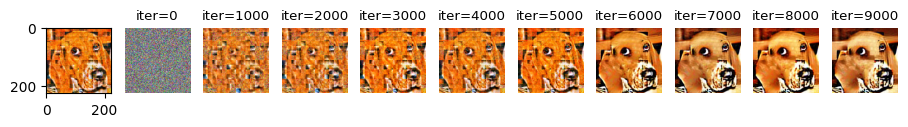

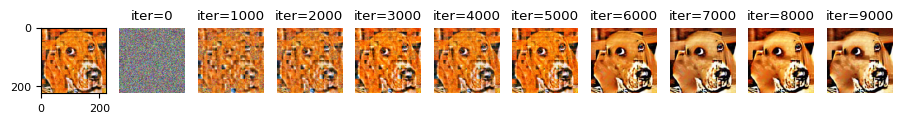

In [23]:
import traceback
try:
    result = attacker.group_attack(received_gradients, batch_size=batch_size)
except:
    traceback.print_exc()

<Figure size 700x800 with 0 Axes>

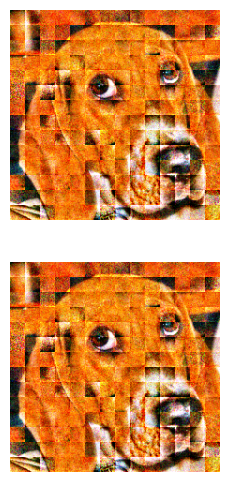

In [24]:
plt.figure(figsize=(7,8))
multi_plot(torch.stack(result[0], dim=0).squeeze(),ds,dm)